In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import fcluster

In [3]:
# Paso 1: Carga de datos

# Cargar el archivo
#archivo = "C:/Users/johnospa/OneDrive - Seguros Suramericana, S.A/Escritorio/universidad_borrar/BD_Pendientes_No_Revisadas.xlsx"
#df = pd.read_excel(archivo)
# Mostrar las primeras filas
#df.head()

#Carga de datos
df = pd.read_excel("/content/BD_Pendientes_No_Revisadas.xlsx")
df.head()

,RESPUESTA,SERVICIO,OBSERVACION_ACTUAL,CONSUMO_CRITICADO,FUNCION_ANALISIS,CALIFICACION
0,1,101-AGUA POTABLE,31-MEDIDOR CAMBIADO,81.58,PEOBTECOPP - Obtener Consumo Promedio Individu...,2-ENVÍA A CRÍTICA
1,1,101-AGUA POTABLE,39-VER ALFANUMERICA,408.00,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%)
2,1,101-AGUA POTABLE,35-NO HAY JUSTIFICACION,-3.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,5036-BAJO ACUEDUCTO (<-65%)
3,1,101-AGUA POTABLE,35-NO HAY JUSTIFICACION,-377.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,5036-BAJO ACUEDUCTO (<-65%)
4,0,101-AGUA POTABLE,0-SIN CAUSA NI OBSERVACIÓN,11.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,2-ENVÍA A CRÍTICA


In [4]:
df['CODIGO_SERVICIO'] = df['SERVICIO'].str.split('-', n=1).str[0]
df.drop(columns=['SERVICIO'], inplace=True)

df['CODIGO_OBSERVACION'] = df['OBSERVACION_ACTUAL'].str.split('-', n=1).str[0]
df.drop(columns=['OBSERVACION_ACTUAL'], inplace=True)

df['CODIGO_CALIFICACION'] = df['CALIFICACION'].str.split('-', n=1).str[0]
df.drop(columns=['CALIFICACION'], inplace=True)

df

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
0,1,81.58,PEOBTECOPP - Obtener Consumo Promedio Individu...,101,31,2
1,1,408.00,CALCCOLE - Calcular Consumo por Lecturas,101,39,5080
2,1,-3.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,35,5036
3,1,-377.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,35,5036
4,0,11.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,0,2
...,...,...,...,...,...,...
96340,1,0.00,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2
96341,1,186.50,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2
96342,1,0.00,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,23,2
96343,1,21.50,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2


Ahora el data set incluye las columnas CODIGO_SERVICIO, CODIGO_OBSERVACION y CODIGO_CALIFICACION, y se han eliminado las columnas SERVICIO, OBSERVACION_ACTUAL y CALIFICACION.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Copiar el DataFrame para trabajar sobre una nueva variable
df_modelo = df.copy()

# Columnas categóricas a codificar
columnas_categoricas = ['FUNCION_ANALISIS']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

# Verificar resultado
df_modelo.head()

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
0,1,81.58,10,101,31,2
1,1,408.00,3,101,39,5080
2,1,-3.00,7,101,35,5036
3,1,-377.00,7,101,35,5036
4,0,11.00,7,101,0,2


Se codifica la columna FUNCION_ANALISIS del conjunto de datos utilizando LabelEncoder. Para volver numerica la variable

In [6]:
df_modelo.corr()

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
RESPUESTA,1.000000,0.004604,-0.004977,0.025184,0.213283,0.076109
CONSUMO_CRITICADO,0.004604,1.000000,0.000448,-0.000889,0.001564,-0.006869
FUNCION_ANALISIS,-0.004977,0.000448,1.000000,-0.042977,-0.264632,-0.487162
CODIGO_SERVICIO,0.025184,-0.000889,-0.042977,1.000000,-0.131297,0.053807
CODIGO_OBSERVACION,0.213283,0.001564,-0.264632,-0.131297,1.000000,0.382600
CODIGO_CALIFICACION,0.076109,-0.006869,-0.487162,0.053807,0.382600,1.000000


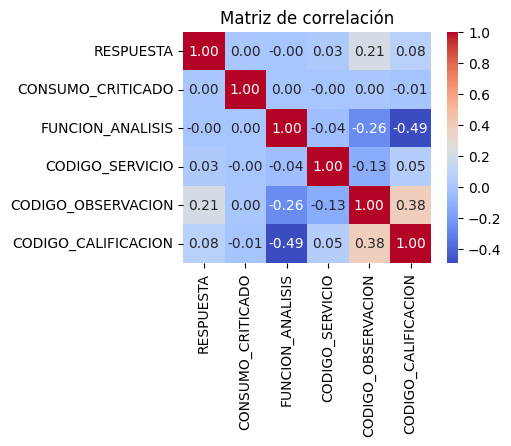

In [7]:
# Verificamos correlación entre numéricas
plt.figure(figsize=(4, 3))
sns.heatmap(df_modelo.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Correlación positiva alta:
CODIGO_OBSERVACION y CODIGO_CALIFICACION: La correlación entre estos dos es de 0.38, lo que indica que a medida que uno aumenta, el otro también tiende a aumentar.

Correlación negativa alta:
FUNCION_ANALISIS y CODIGO_CALIFICACION: La correlación entre estos dos es de -0.49, lo que sugiere que a medida que uno aumenta, el otro tiende a disminuir.

Correlaciones bajas:
La mayoría de las otras correlaciones son bajas, lo que indica que no hay una relación fuerte entre esas variables.

En resumen, las correlaciones más significativas son entre CODIGO_OBSERVACION y CODIGO_CALIFICACION (positiva) y entre FUNCION_ANALISIS y CODIGO_CALIFICACION (negativa). Estas relaciones pueden ser útiles para entender cómo ciertas variables están interconectadas y pueden influir en el análisis de datos.

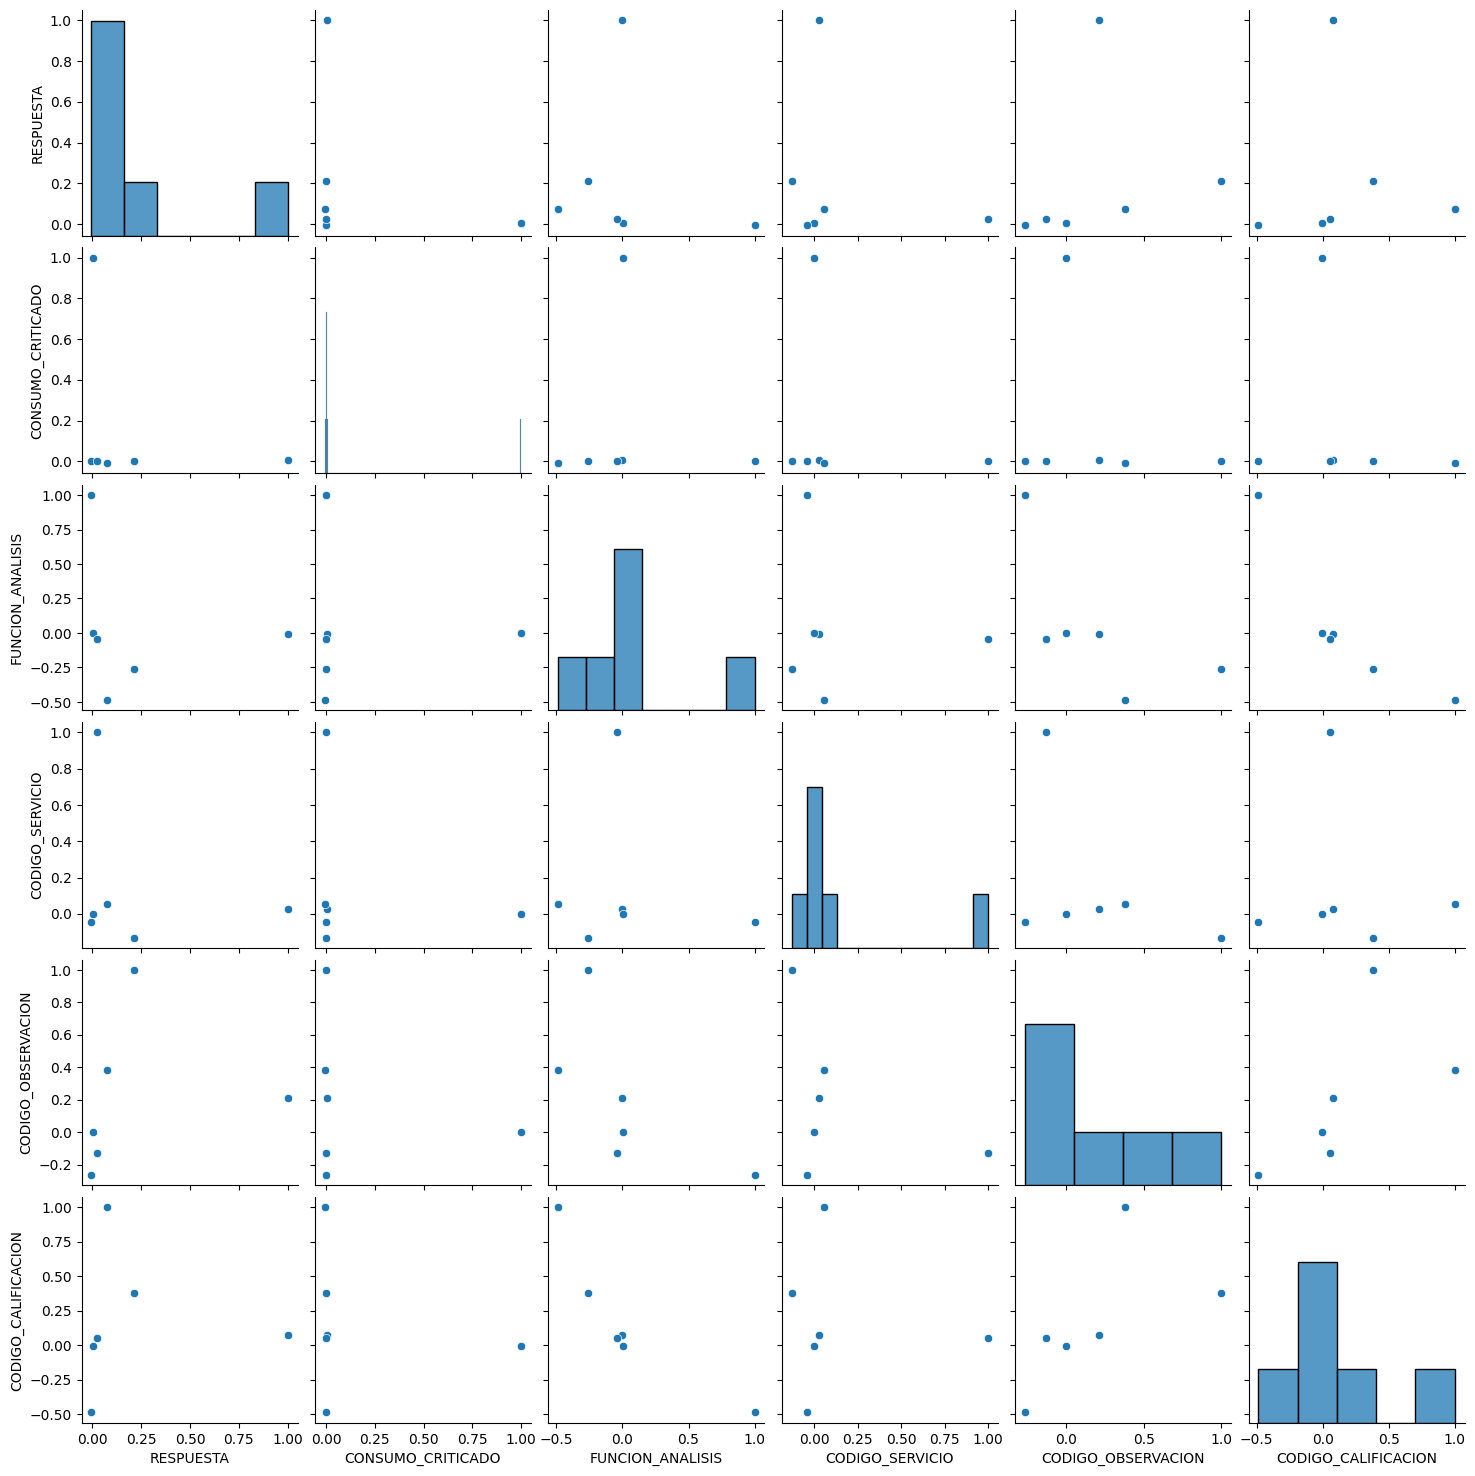

In [ ]:
sns.pairplot(df_modelo.corr())

Relaciones Positivas:
CODIGO_OBSERVACION y CODIGO_CALIFICACION: Se observa una correlación positiva moderada, lo que indica que a medida que uno aumenta, el otro también tiende a aumentar.
RESPUESTA y CONSUMO_CRITICADO: También hay una correlación positiva entre estas dos variables, sugiriendo que pueden estar relacionadas en el contexto del análisis.

Relaciones Negativas:
FUNCION_ANALISIS y CODIGO_CALIFICACION: Se observa una correlación negativa, lo que sugiere que a medida que una variable aumenta, la otra tiende a disminuir.
CODIGO_SERVICIO y CODIGO_OBSERVACION: Hay una correlación negativa entre estas dos variables, indicando una posible relación inversa.

Correlaciones Bajas:
La mayoría de las otras correlaciones son bajas, lo que indica que no hay una relación fuerte entre esas variables.

Implicaciones:
Análisis de Variables: Las correlaciones positivas y negativas pueden ser útiles para identificar variables que tienen una relación significativa y pueden influir en el análisis de datos.
Modelado Predictivo: Las variables con alta correlación pueden ser consideradas para modelado predictivo, ya que pueden proporcionar información valiosa sobre las relaciones entre diferentes aspectos del conjunto de datos.

In [ ]:
#Analisis de media, mediana y moda para cada una de las tres variables a analizar para el modelo.
numericas = ["CONSUMO_CRITICADO"]
for col in ["CONSUMO_CRITICADO"]:
  media = df_modelo[col].mean()
  mediana = df_modelo[col].median()
  moda = df_modelo[col].mode()[0]
  print(f"Análisis descriptivo de la columna: {col}")
  print(f'La media de la columna {col} es: {media}')
  print(f'La mediana de la columna {col} es: {mediana}')
  print(f'La moda de la columna {col} es: {moda}')
  print("-" * 20)

Análisis descriptivo de la columna: CONSUMO_CRITICADO
La media de la columna CONSUMO_CRITICADO es: 17564381.169776127
La mediana de la columna CONSUMO_CRITICADO es: 12.72
La moda de la columna CONSUMO_CRITICADO es: 0.0
--------------------


Media:
La media de CONSUMO_CRITICADO es 17,564,381.17. Este valor es extremadamente alto, lo que sugiere que hay valores atípicos muy grandes en la columna que están influyendo en el promedio.

Mediana:
La mediana de CONSUMO_CRITICADO es 12.72. La mediana es mucho más baja que la media, lo que indica que la mayoría de los datos están concentrados en valores más bajos y que los valores atípicos están elevando la media.

Moda:
La moda de CONSUMO_CRITICADO es 0.0. Esto significa que el valor más frecuente en la columna es 0, lo que sugiere que hay muchos registros con un consumo criticado de 0.

Implicaciones:
Distribución de Datos: La gran diferencia entre la media y la mediana indica una distribución sesgada, donde la mayoría de los datos están en el rango bajo, pero hay algunos valores extremadamente altos que afectan la media.
Valores Atípicos: Los valores atípicos pueden ser importantes para el análisis, ya que pueden representar casos especiales o errores en los datos que necesitan ser investigados.
Decisiones de Modelado: Para el modelado predictivo, puede ser útil considerar técnicas de preprocesamiento como la normalización o la eliminación de valores atípicos para mejorar la precisión del modelo.

In [ ]:
#Generacion de medidas de tendencia central: desviacion estandar, varianza con sus respectivos minimos, rangos y maximos.
for col in numericas:
    varianza = df_modelo[col].var()
    desviacion = df_modelo[col].std()
    maximo = df_modelo[col].max()
    minimo = df_modelo[col].min()
    rango = maximo - minimo
    print(f"Análisis de la columna: {col}")
    print(f'Varianza = {varianza}')
    print(f'Desviación estándar = {desviacion}')
    print(f'Máximo = {maximo}')
    print(f'Mínimo = {minimo}')
    print(f'Rango = {rango}')
    print("-" * 20)

Análisis de la columna: CONSUMO_CRITICADO
Varianza = 7.644144316956561e+18
Desviación estándar = 2764804571.20509
Máximo = 733315443334.145
Mínimo = -1600808.0
Rango = 733317044142.145
--------------------


Varianza:
La varianza de CONSUMO_CRITICADO es 7.644144316960542e+18. Este valor extremadamente alto indica una gran dispersión de los datos alrededor de la media, lo que sugiere la presencia de valores muy variados y posiblemente atípicos.

Desviación Estándar:
La desviación estándar es 2,764,804,571.21. Este valor también es muy alto, lo que confirma que los datos están muy dispersos y que hay una gran variabilidad en los valores de CONSUMO_CRITICADO.

Máximo y Mínimo:
El valor máximo es 733,315,443,334.145 y el valor mínimo es -1,600,808.0. La diferencia entre estos valores muestra un rango extremadamente amplio, lo que indica la presencia de valores atípicos significativos.

Rango:
El rango es 733,317,044,142.145. Este amplio rango refuerza la idea de que los datos tienen una gran variabilidad y que hay valores extremos que afectan la distribución.

Implicaciones:
Distribución de Datos: La alta varianza y desviación estándar, junto con el amplio rango, sugieren que los datos de CONSUMO_CRITICADO están muy dispersos y que hay valores atípicos significativos.
Valores Atípicos: Los valores extremos pueden ser importantes para el análisis, ya que pueden representar casos especiales o errores en los datos que necesitan ser investigados.
Decisiones de Modelado: Para el modelado predictivo, puede ser útil considerar técnicas de preprocesamiento como la normalización o la eliminación de valores atípicos para mejorar la precisión del modelo.

In [ ]:
#Generacion de las medidas de variabilidad: curtosis y asimetria
for col in numericas:
    asimetria = df_modelo[col].skew()
    curtosis = df_modelo[col].kurt()
    print(f"Análisis de la columna: {col}")
    print(f'Asimetría = {asimetria}')
    print(f'Curtosis = {curtosis}')
    print("-" * 20)

Análisis de la columna: CONSUMO_CRITICADO
Asimetría = 223.57145610476437
Curtosis = 55000.94786198027
--------------------


Asimetría:
La asimetría de CONSUMO_CRITICADO es 223.57. Este valor extremadamente alto indica que la distribución de los datos está muy sesgada hacia la derecha. En otras palabras, hay una cola larga en el lado derecho de la distribución, lo que sugiere la presencia de valores atípicos extremadamente altos.

Curtosis:
La curtosis de CONSUMO_CRITICADO es 55000.95. Este valor también es extremadamente alto, lo que indica que la distribución tiene colas muy pesadas. Esto significa que hay muchos valores extremos (tanto altos como bajos) en comparación con una distribución normal.

Implicaciones:
Distribución de Datos: La alta asimetría y curtosis sugieren que la distribución de CONSUMO_CRITICADO no es normal y está influenciada por valores atípicos significativos.
Valores Atípicos: Los valores extremos pueden ser importantes para el análisis, ya que pueden representar casos especiales o errores en los datos que necesitan ser investigados.
Decisiones de Modelado: Para el modelado predictivo, puede ser útil considerar técnicas de preprocesamiento como la normalización, transformación logarítmica o la eliminación de valores atípicos para mejorar la precisión del modelo.

In [ ]:
#Tercios
Q1 = np.percentile(df_modelo['CONSUMO_CRITICADO'],33)
Q2 = np.percentile(df_modelo['CONSUMO_CRITICADO'],66)
print(Q1,Q2)
print('El 33% de los valores para CONSUMO_CRITICADO son menores o iguales a:', Q1)
print('El 66% de los valores para CONSUMO_CRITICADO son menores o iguales a:', Q2)

1.0 51.0
El 33% de los valores para CONSUMO_CRITICADO son menores o iguales a: 1.0
El 66% de los valores para CONSUMO_CRITICADO son menores o iguales a: 51.0


Primer Tercio (Q1):
El primer tercio (Q1) es 1.0, lo que significa que el 33% de los valores de CONSUMO_CRITICADO son menores o iguales a 1.0. Esto indica que una gran parte de los datos está concentrada en valores muy bajos.

Segundo Tercio (Q2):
El segundo tercio (Q2) es 51.0, lo que significa que el 66% de los valores de CONSUMO_CRITICADO son menores o iguales a 51.0. Esto sugiere que la mayoría de los datos están en el rango bajo, pero hay una dispersión significativa que lleva algunos valores hasta 51.

Implicaciones:
Distribución de Datos: La mayoría de los valores de CONSUMO_CRITICADO están concentrados en el rango bajo, con un pequeño porcentaje de valores que son significativamente más altos.
Valores Atípicos: Los valores superiores a 51 representan el 34% restante de los datos, lo que indica la presencia de valores atípicos que pueden influir en el análisis.
Decisiones de Modelado: Para el modelado predictivo, puede ser útil considerar técnicas de preprocesamiento como la normalización o la eliminación de valores atípicos para mejorar la precisión del modelo.

In [ ]:
#Cuartiles
Cuartil1 = np.percentile(df_modelo['CONSUMO_CRITICADO'],25)
Cuartil2 = np.percentile(df_modelo['CONSUMO_CRITICADO'],50)
Cuartil3 = np.percentile(df_modelo['CONSUMO_CRITICADO'],75)
print(Cuartil1,Cuartil2,Cuartil3)
print('El 25% de los valores para CONSUMO_CRITICADO son menores o iguales a:', Cuartil1)
print('El 50% de los valores para CONSUMO_CRITICADO son menores o iguales a:', Cuartil2)
print('El 75% de los valores para CONSUMO_CRITICADO son menores o iguales a:', Cuartil3)

0.0 12.72 175.0
El 25% de los valores para CONSUMO_CRITICADO son menores o iguales a: 0.0
El 50% de los valores para CONSUMO_CRITICADO son menores o iguales a: 12.72
El 75% de los valores para CONSUMO_CRITICADO son menores o iguales a: 175.0


Primer Cuartil (Q1):
El primer cuartil (Q1) es 0.0, lo que significa que el 25% de los valores de CONSUMO_CRITICADO son menores o iguales a 0.0. Esto indica que una cuarta parte de los datos tiene un valor de consumo criticado de 0.

Segundo Cuartil (Q2):
El segundo cuartil (Q2) es 12.72, lo que significa que el 50% de los valores de CONSUMO_CRITICADO son menores o iguales a 12.72. Este valor también es la mediana, indicando que la mitad de los datos está por debajo de este valor.

Tercer Cuartil (Q3):
El tercer cuartil (Q3) es 175.0, lo que significa que el 75% de los valores de CONSUMO_CRITICADO son menores o iguales a 175.0. Esto sugiere que la mayoría de los datos están en el rango bajo, pero hay una dispersión significativa que lleva algunos valores hasta 175.

Implicaciones:
Distribución de Datos: La mayoría de los valores de CONSUMO_CRITICADO están concentrados en el rango bajo, con un pequeño porcentaje de valores que son significativamente más altos.
Valores Atípicos: Los valores superiores a 175 representan el 25% restante de los datos, lo que indica la presencia de valores atípicos que pueden influir en el análisis.
Decisiones de Modelado: Para el modelado predictivo, puede ser útil considerar técnicas de preprocesamiento como la normalización o la eliminación de valores atípicos para mejorar la precisión del modelo.

Revisar si se agrega

In [ ]:
#Tabla de frecuencia con los intervalos automáticos

def tabla_frecuencia(df_modelo):
  columna = df_modelo['CONSUMO_CRITICADO']
  n = len(columna)
  k = math.ceil(1+math.log2(n))
  min_val = min(columna)
  max_val = max(columna)
  rango = max_val - min_val
  amplitud = rango/k

  #Definir los intervalos
  bins = np.linspace(min_val,max_val,k+1)

  #Calcular las frecuencias
  frecuencias, _ = np.histogram(columna, bins)

  #Calcular las frecuencias acumuladas
  frec_acumulada = np.cumsum(frecuencias)

  #Calcular las frecuencias relativas
  frecuencia_relativa = frecuencias/n

  #Calcular la fecuencia relativa acumulada
  frecuencia_relativa_acumulada = np.cumsum(frecuencia_relativa)

  #Crear las tablas de frecuencia
  tabla = pd.DataFrame({
      'Intervalo': [f'{bins[i]:.2f},{bins[i+1]:.2f})' for i in range(len(bins)-1)],
      'Frecuencia': frecuencias,
      'Frecuencia_Acumulada': frec_acumulada,
      'Frecuencia_Relativa': frecuencia_relativa,
      'Frecuencia_Relativa_Acumulada': frecuencia_relativa_acumulada
  }
  )

  return tabla

# Aplicar función al DataFrame
resultado = tabla_frecuencia(df_modelo)
print(resultado)

                           Intervalo  Frecuencia  Frecuencia_Acumulada  \
0        -1600808.00,40738234977.67)       96339                 96339   
1     40738234977.67,81478070763.35)           2                 96341   
2    81478070763.35,122217906549.02)           1                 96342   
3   122217906549.02,162957742334.70)           0                 96342   
4   162957742334.70,203697578120.37)           0                 96342   
5   203697578120.37,244437413906.05)           1                 96343   
6   244437413906.05,285177249691.72)           0                 96343   
7   285177249691.72,325917085477.40)           0                 96343   
8   325917085477.40,366656921263.07)           0                 96343   
9   366656921263.07,407396757048.75)           1                 96344   
10  407396757048.75,448136592834.42)           0                 96344   
11  448136592834.42,488876428620.10)           0                 96344   
12  488876428620.10,529616264405.77)  

Conclusiones:
Distribución de Frecuencias:

La mayoría de los datos se encuentran en el primer intervalo, con una frecuencia de 96,339.
Los intervalos restantes tienen frecuencias muy bajas, con la mayoría de ellos teniendo una frecuencia de 0.
Frecuencia Relativa:

La frecuencia relativa del primer intervalo es casi 1, lo que indica que casi todos los datos están en este intervalo.
Las frecuencias relativas de los otros intervalos son extremadamente bajas.
Frecuencia Acumulada:

La frecuencia acumulada aumenta rápidamente en el primer intervalo y se mantiene casi constante en los intervalos siguientes.
Frecuencia Relativa Acumulada:

La frecuencia relativa acumulada alcanza casi 1 en el primer intervalo y se mantiene constante en los intervalos siguientes.
Esto sugiere que la mayoría de los valores de CONSUMO_CRITICADO están concentrados en un rango muy estrecho, con algunos valores atípicos que se extienden a intervalos mucho más altos.

Se debe dividir los datos, por que si se hace con toda la informacion, genera error de memoria.

In [ ]:
#filtrar datos
datos = df_modelo[df_modelo["CODIGO_SERVICIO"] == "103"]
correlacion1 = datos[["RESPUESTA","CONSUMO_CRITICADO"]]
#sns.pairplot(correlacion1)

Distribución de Datos:
La mayoría de los valores de CONSUMO_CRITICADO son bajos, con muchos registros teniendo un valor de 0.
Hay algunos valores más altos, como 117.701 y 16.000, que indican la presencia de valores atípicos.

Correlación:
Dado que la columna RESPUESTA tiene un valor constante de 1, no habrá una correlación significativa entre RESPUESTA y CONSUMO_CRITICADO. La correlación requiere variabilidad en ambas columnas para identificar una relación.

Implicaciones:
Análisis de Datos: La falta de variabilidad en la columna RESPUESTA sugiere que esta columna no proporcionará información útil para el análisis de correlación.
Valores Atípicos: Los valores más altos de CONSUMO_CRITICADO pueden ser importantes para investigar más a fondo, ya que pueden representar casos especiales o errores en los datos.

In [ ]:
#La matriz de correlaciones
correlacion_matrix =correlacion1.corr()
correlacion1.corr()

,RESPUESTA,CONSUMO_CRITICADO
RESPUESTA,1.000000,0.016886
CONSUMO_CRITICADO,0.016886,1.000000


Correlación entre RESPUESTA y CONSUMO_CRITICADO:
La correlación entre RESPUESTA y CONSUMO_CRITICADO es 0.016886. Este valor es muy cercano a 0, lo que indica que no hay una relación lineal significativa entre estas dos variables. En otras palabras, los cambios en CONSUMO_CRITICADO no están asociados con cambios en RESPUESTA.

Correlación entre CONSUMO_CRITICADO y RESPUESTA:
La correlación entre CONSUMO_CRITICADO y RESPUESTA es también 0.016886, lo que confirma la falta de relación lineal significativa entre estas dos variables.

Implicaciones:
Análisis de Datos: La falta de correlación significativa sugiere que RESPUESTA y CONSUMO_CRITICADO no están relacionados de manera que uno pueda predecir el otro. Esto puede ser importante para decidir qué variables incluir en modelos predictivos o análisis adicionales.
Decisiones de Modelado: Dado que no hay una relación significativa entre estas dos variables, puede ser útil explorar otras variables que puedan tener una correlación más fuerte y proporcionar información más valiosa para el modelado predictivo.

<Axes: >

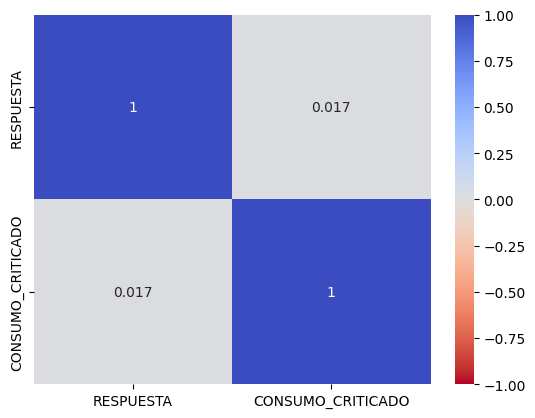

In [ ]:
sns.heatmap(correlacion_matrix, annot=True, cmap="coolwarm_r",center=0,vmin=-1,vmax=1)

PCA

In [ ]:
scaler =StandardScaler()
continuas_scaled = scaler.fit_transform(correlacion1)
pca = PCA()
res_pca = pca.fit(continuas_scaled)
np.set_printoptions(suppress=True)

print('Valores propios (Varianza explicada en cada compenente):')
print(np.round(res_pca.explained_variance_, 2))

print('Proporcion de varianza explicada:')
print(np.round(res_pca.explained_variance_ratio_,2))

print('Cargas de los componentes:')
print(np.round(res_pca.components_,2))

Valores propios (Varianza explicada en cada compenente):
[1.03 1.  ]
Proporcion de varianza explicada:
[0.51 0.49]
Cargas de los componentes:
[[ 0.71  0.71]
 [-0.71  0.71]]


Valores propios (Varianza explicada en cada componente):
Esto indica que la primera componente principal explica una varianza de 1.03, mientras que la segunda componente principal explica una varianza de 1.00.

Proporción de varianza explicada:
La primera componente principal explica el 51% de la varianza total, mientras que la segunda componente principal explica el 49% de la varianza total.

Cargas de los componentes:
Las cargas de los componentes indican cómo cada variable contribuye a cada componente principal. En este caso:

La primera componente principal tiene cargas positivas similares para ambas variables (RESPUESTA y CONSUMO_CRITICADO), lo que sugiere que ambas variables contribuyen de manera similar a esta componente.
La segunda componente principal tiene una carga positiva para CONSUMO_CRITICADO y una carga negativa para RESPUESTA, lo que indica que estas variables tienen una relación inversa en esta componente.
Conclusiones:
Varianza Explicada:

La primera componente principal explica ligeramente más de la mitad de la varianza total, lo que sugiere que es la más importante para capturar la variabilidad en los datos.
La segunda componente principal también explica una cantidad significativa de varianza, lo que indica que ambas componentes son importantes para entender la estructura de los datos.
Cargas de los Componentes:

Las cargas de los componentes muestran que RESPUESTA y CONSUMO_CRITICADO contribuyen de manera similar a la primera componente principal.
La relación inversa en la segunda componente principal sugiere que hay una diferencia en cómo estas variables se comportan en esta dimensión.
Implicaciones:
Reducción de Dimensionalidad: El PCA puede ser útil para reducir la dimensionalidad de los datos y capturar la mayor parte de la variabilidad con menos componentes.
Análisis de Datos: Las componentes principales pueden proporcionar información valiosa sobre las relaciones entre las variables y ayudar a identificar patrones en los datos.


In [ ]:
#Mejor visualización de los resultados
cumVar = pd.DataFrame(np.cumsum(res_pca.explained_variance_ratio_)*100,
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(res_pca.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1).rename(index={0:"PC1", 1:"PC2", 2:"PC3"})

,VarPerc,cumVarPerc
PC1,50.844276,50.844276
PC2,49.155724,100.000000


Varianza Explicada:
PC1 (Primera Componente Principal): Explica el 50.84% de la varianza total. Esto indica que esta componente captura la mayor parte de la variabilidad en los datos.
PC2 (Segunda Componente Principal): Explica el 49.16% de la varianza total. Aunque es ligeramente menor que la primera componente, sigue siendo significativa y captura una gran parte de la variabilidad.

Varianza Acumulada:
PC1: La varianza acumulada después de la primera componente es del 50.84%.
PC2: La varianza acumulada después de la segunda componente es del 100%, lo que significa que estas dos componentes juntas explican toda la variabilidad en los datos.

Implicaciones:
Reducción de Dimensionalidad: El PCA ha reducido efectivamente la dimensionalidad de los datos, capturando la mayor parte de la variabilidad con solo dos componentes principales.
Análisis de Datos: Las componentes principales pueden proporcionar información valiosa sobre las relaciones entre las variables y ayudar a identificar patrones en los datos.
Modelado Predictivo: Utilizar las componentes principales en lugar de las variables originales puede mejorar la eficiencia y precisión de los modelos predictivos.

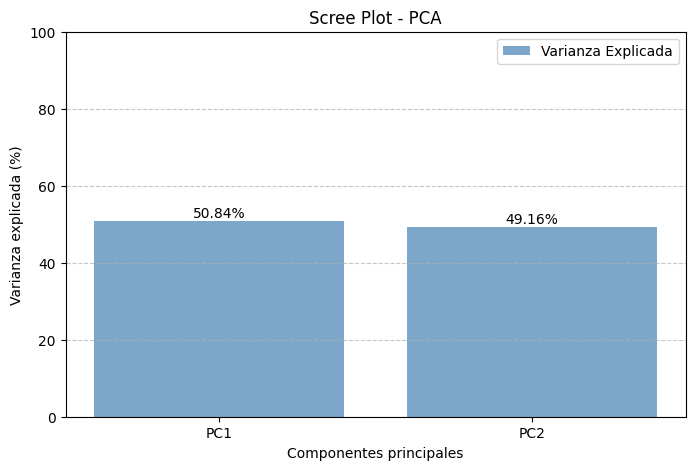

In [ ]:
#Visualización del PCA
plt.figure(figsize=(8,5))
plt.bar(range(1, len(res_pca.explained_variance_ratio_)+1),
        res_pca.explained_variance_ratio_*100,
        alpha=0.7, color="Steelblue", label = "Varianza Explicada"
        )

for i, var in enumerate(res_pca.explained_variance_ratio_*100):
  plt.text(i+1, var+1, f"{var:.2f}%", ha='center', fontsize=10)

plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada (%)")
plt.title("Scree Plot - PCA")
plt.ylim(0, 100)
plt.xticks(range(1, len(res_pca.explained_variance_ratio_)+1),
             [f"PC{i+1}" for i in range(len(res_pca.explained_variance_ratio_))])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

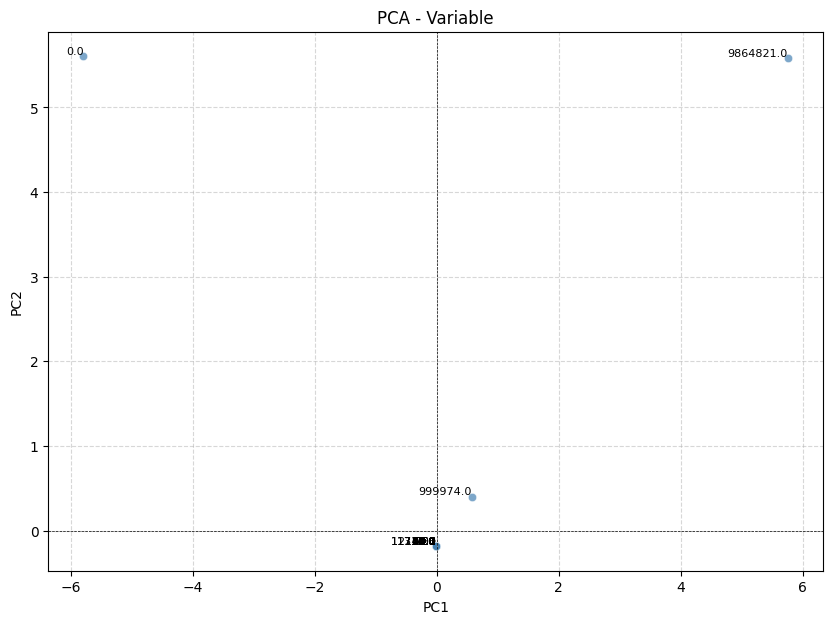

In [ ]:
#Gráfico de biplot
pred = res_pca.transform(continuas_scaled)
df_pred = pd.DataFrame(pred, columns=[f"PC{i+1}" for i in range(pred.shape[1])])
df_pca_scores = df_pred
variable = datos.iloc[:, 1]
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca_scores["PC1"], y=df_pca_scores["PC2"], color="steelblue", alpha=0.7)

for i, varia in enumerate(variable):
  plt.text(df_pca_scores["PC1"][i], df_pca_scores["PC2"][i], varia, fontsize=8, ha='right', va='bottom')

plt.axhline(0, color='black', linewidth=0.5, linestyle="--")
plt.axvline(0, color='black', linewidth=0.5, linestyle="--")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - Variable")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Distribución de Datos:
El gráfico muestra la distribución de los datos en el espacio de las dos primeras componentes principales (PC1 y PC2).
La mayoría de los puntos están concentrados cerca del origen, lo que indica que la mayoría de los datos tienen valores bajos en ambas componentes principales.

Valores Atípicos:
Hay algunos puntos dispersos lejos del origen, lo que sugiere la presencia de valores atípicos. Estos puntos pueden representar casos especiales o errores en los datos que necesitan ser investigados.

Relaciones entre Variables:
La dispersión de los puntos en el gráfico puede proporcionar información sobre las relaciones entre las variables RESPUESTA y CONSUMO_CRITICADO. La orientación y la concentración de los puntos pueden ayudar a identificar patrones y tendencias en los datos.

Implicaciones:
Análisis de Datos: El biplot es una herramienta útil para visualizar la estructura de los datos y entender cómo las variables están relacionadas en el espacio de las componentes principales.
Modelado Predictivo: Utilizar las componentes principales en lugar de las variables originales puede mejorar la eficiencia y precisión de los modelos predictivos.
Investigación de Valores Atípicos: Los puntos dispersos lejos del origen pueden ser importantes para investigar más a fondo, ya que pueden representar casos especiales o errores en los datos.

In [ ]:
#los scores PCA
pred = res_pca.transform(continuas_scaled)
df_pred = pd.DataFrame(pred, columns=[f"PC{i+1}" for i in range(pred.shape[1])])
print(df_pred.head(10))

        PC1       PC2
0 -0.008556 -0.183968
1 -0.008554 -0.183965
2 -0.008556 -0.183968
3 -0.008556 -0.183968
4 -0.008488 -0.183899
5 -0.008555 -0.183967
6 -0.008492 -0.183903
7 -0.008556 -0.183968
8 -0.008543 -0.183955
9 -0.008551 -0.183963


Distribución de Scores:
Los scores PCA muestran cómo los datos se proyectan en el espacio de las componentes principales. En este caso, los valores de PC1 y PC2 son bastante similares y cercanos a cero, lo que indica que los datos están concentrados cerca del origen en el espacio de las componentes principales.

Variabilidad:
La variabilidad en los scores de PC2 es mayor que en PC1, lo que sugiere que la segunda componente principal captura más variabilidad en los datos.

Interpretación:
Los scores PCA pueden ser utilizados para identificar patrones y relaciones en los datos. En este caso, la similitud de los scores sugiere que las variables RESPUESTA y CONSUMO_CRITICADO tienen una relación similar en el espacio de las componentes principales.

Cluster

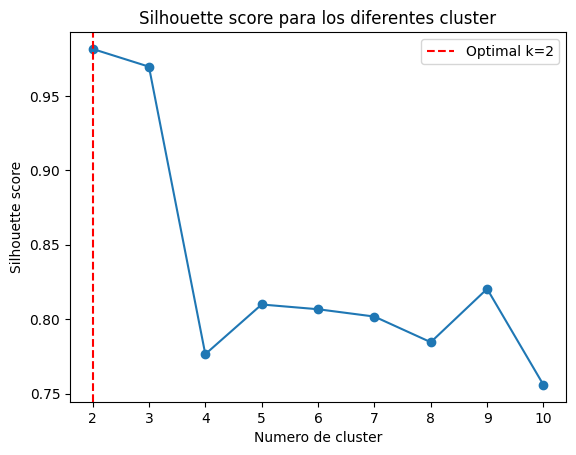

In [ ]:
data = datos[["RESPUESTA","CONSUMO_CRITICADO"]]
def fviz_nbclust(data, max_k):
  silhouette_scores = []
  for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)


  plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
  plt.title('Silhouette score para los diferentes cluster')
  plt.xlabel('Numero de cluster')
  plt.ylabel('Silhouette score')

  optimal_k = np.argmax(silhouette_score) + 2
  plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
  plt.legend()
  plt.show()

fviz_nbclust(data,max_k=10)

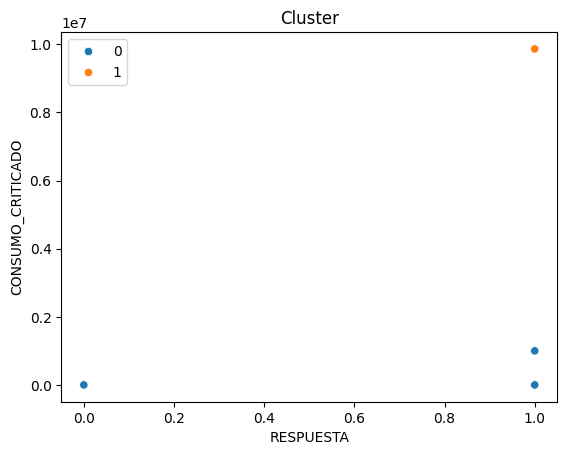

In [ ]:
#El cálculo del clúster N=2 grupos
variableCluster = datos.iloc[:,1].values
model = AgglomerativeClustering(n_clusters=2)
model.fit(data)
labels = model.labels_
cluster_df = pd.DataFrame({'Variable':variableCluster, 'Cluster':labels})
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=model.labels_)
plt.title('Cluster')
plt.show()

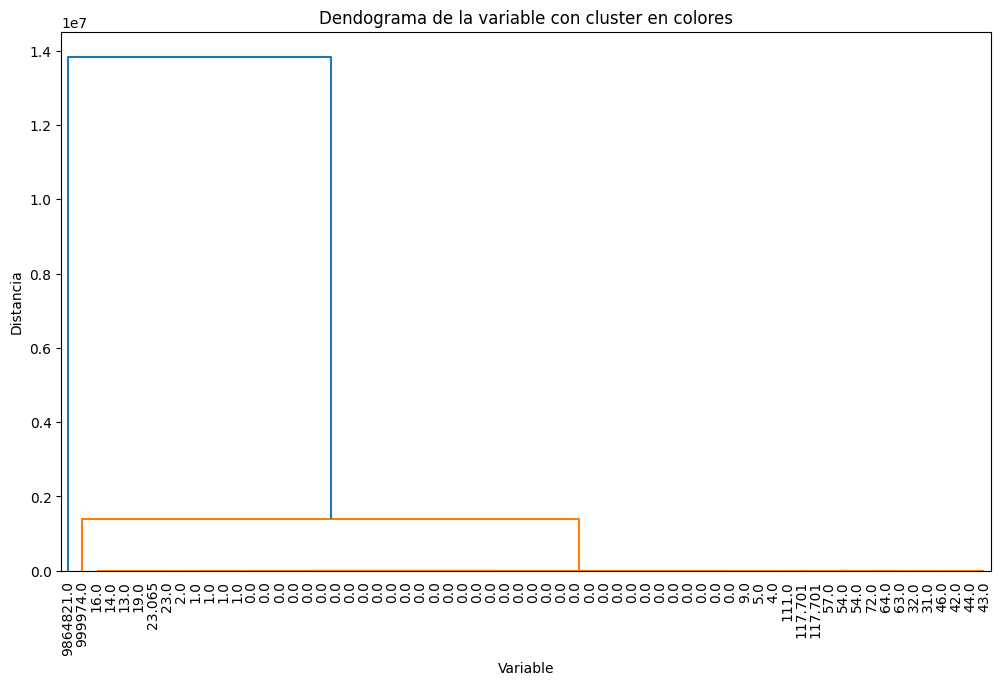

In [ ]:
#Dendograma
variableCluster = datos.iloc[:,1].values
modeldendo = sch.linkage(data, method='ward')
threshold = 0.7 * max(modeldendo[:, 2])

plt.figure(figsize=(12,7))
sch.dendrogram(modeldendo, labels=variableCluster, leaf_rotation=90, leaf_font_size=10, color_threshold= threshold)

plt.title('Dendograma de la variable con cluster en colores')
plt.xlabel('Variable')
plt.ylabel('Distancia')
plt.show()